In [ ]:
from dataclasses import dataclass

import numpy as np
import torch
import wandb
from matplotlib import pyplot as plt

from dviforbml.architectures.dvi import DVI
from dviforbml.components.cdvi.cmcd import CMCD
from dviforbml.components.cdvi.dis import DIS
from dviforbml.components.control.aggr_control import AggrControl
from dviforbml.components.control.bca_control import BCAControl
from dviforbml.components.control.mha_control import MHAControl
from dviforbml.components.encoder.aggr_encoder import Aggr, AggrEncoder
from dviforbml.components.encoder.bca_encoder import BCAEncoder
from dviforbml.components.encoder.mha_encoder import MHAEncoder
from dviforbml.components.schedule.annealing_schedule import (
    AggrAnnealingSchedule,
    AnnealingSchedule,
    BCAAnnealingSchedule,
)
from dviforbml.components.schedule.cos_noise_schedule import (
    AggrCosineNoiseSchedule,
    BCACosineNoiseSchedule,
    CosineNoiseSchedule,
)
from dviforbml.components.schedule.noise_schedule import (
    AggrNoiseSchedule,
    BCANoiseSchedule,
    NoiseSchedule,
)
from dviforbml.components.schedule.step_size_schedule import StepSizeSchedule
from dviforbml.training.dvi_trainer import DVITrainerContext
from dviforbml.utils.datasets import ContextSetDataset
from dviforbml.utils.distros import TaskPosteriorGMM
from dviforbml.evaluation.visualization.visualize_dvi import visualize_dvi_2d

In [ ]:
try:
    import torch_directml

    device = torch_directml.device()
except ImportError:
    device = torch.device("cpu")

device = torch.device("cpu")

In [ ]:
@dataclass
class Config:
    num_steps = 16
    c_dim = 2
    z_dim = 2
    h_dim = 32
    num_layers = 3
    non_linearity = "GELU"
    use_score = False
    learning_rate = 3e-3
    size = 64
    batch_size = 64


config = Config()

In [ ]:
dataset = ContextSetDataset(
    size=config.size, c_dim=config.c_dim, max_context_size=10, sampling_factor=4
)
dataloader = DataLoader(dataset=dataset, batch_size=config.batch_size, shuffle=True)

In [ ]:
contextual_target = TaskPosteriorGMM

aggr_encoder = AggrEncoder(
    c_dim=config.c_dim,
    h_dim=config.h_dim,
    num_layers=config.num_layers,
    non_linearity=config.non_linearity,
    num_heads=None,
    aggregation=Aggr.MEAN,
    max_context_size=None,  # dataset.max_context_size
)

bca_encoder = BCAEncoder(
    c_dim=config.c_dim,
    h_dim=config.h_dim,
    z_dim=config.z_dim,
    num_layers=config.num_layers,
    non_linearity=config.non_linearity,
    num_heads=None,
)

mha_encoder = MHAEncoder(
    c_dim=config.c_dim,
    h_dim=config.h_dim,
    num_layers=config.num_layers,
    non_linearity=config.non_linearity,
    num_heads=1,
)

aggr_control = AggrControl(
    h_dim=config.h_dim,
    z_dim=config.z_dim,
    num_steps=config.num_steps,
    num_layers=config.num_layers,
    non_linearity=config.non_linearity,
    use_score=config.use_score,
    use_error=False,
)

bca_control = BCAControl(
    h_dim=config.h_dim,
    z_dim=config.z_dim,
    num_steps=config.num_steps,
    num_layers=config.num_layers,
    non_linearity=config.non_linearity,
    use_score=config.use_score,
    use_error=False,
)

mha_control = MHAControl(
    h_dim=config.h_dim,
    z_dim=config.z_dim,
    num_steps=config.num_steps,
    num_layers=config.num_layers,
    non_linearity=config.non_linearity,
    use_score=config.use_score,
    num_heads=1,
)

step_size_schedule = StepSizeSchedule(num_steps=config.num_steps, device=device)

noise_schedule = NoiseSchedule(
    z_dim=config.z_dim,
    num_steps=config.num_steps,
    device=device,
)

aggr_noise_schedule = AggrNoiseSchedule(
    z_dim=config.z_dim,
    h_dim=config.h_dim,
    non_linearity=config.non_linearity,
    num_steps=config.num_steps,
    device=device,
)

bca_noise_schedule = BCANoiseSchedule(
    z_dim=config.z_dim,
    h_dim=config.h_dim,
    non_linearity=config.non_linearity,
    num_steps=config.num_steps,
    device=device,
)

# mha_noise_schedule = MHANoiseSchedule(
#     z_dim=config.z_dim,
#     h_dim=config.h_dim,
#     non_linearity=config.non_linearity,
#     num_steps=config.num_steps,
#     device=device,
#     num_heads=1
# )

annealing_schedule = AnnealingSchedule(num_steps=config.num_steps, device=device)

aggr_annealing_schedule = AggrAnnealingSchedule(
    h_dim=config.h_dim,
    non_linearity=config.non_linearity,
    num_steps=config.num_steps,
    device=device,
)

bca_annealing_schedule = BCAAnnealingSchedule(
    h_dim=config.h_dim,
    non_linearity=config.non_linearity,
    num_steps=config.num_steps,
    device=device,
)

# mha_annealing_schedule = MHAAnnealingSchedule(
#     h_dim=config.h_dim,
#     non_linearity=config.non_linearity,
#     num_steps=config.num_steps,
#     device=device,
#     num_heads=1
# )

cos_noise_schedule = CosineNoiseSchedule(
    z_dim=config.z_dim,
    num_steps=config.num_steps,
    device=device,
)

aggr_cos_noise_schedule = AggrCosineNoiseSchedule(
    z_dim=config.z_dim,
    h_dim=config.h_dim,
    non_linearity=config.non_linearity,
    num_steps=config.num_steps,
)

bca_cos_noise_schedule = BCACosineNoiseSchedule(
    z_dim=config.z_dim,
    h_dim=config.h_dim,
    non_linearity=config.non_linearity,
    num_steps=config.num_steps,
)

comps = (aggr_control, noise_schedule, annealing_schedule, aggr_encoder)
# comps = (aggr_control, aggr_noise_schedule, aggr_annealing_schedule, aggr_encoder)
# comps = (aggr_control, aggr_cos_noise_schedule, aggr_annealing_schedule, aggr_encoder)
# comps = (bca_control, noise_schedule, annealing_schedule, bca_encoder)
# comps = (bca_control, cos_noise_schedule, annealing_schedule, bca_encoder)
# comps = (bca_control, bca_noise_schedule, bca_annealing_schedule, bca_encoder)
# comps = (bca_control, bca_cos_noise_schedule, bca_annealing_schedule, bca_encoder)
# comps = (mha_control, mha_noise_schedule, mha_annealing_schedule, mha_encoder)

cdvi = DIS(
    z_dim=config.z_dim,
    num_steps=config.num_steps,
    control=comps[0],
    step_size_schedule=step_size_schedule,
    noise_schedule=comps[1],
    annealing_schedule=comps[2],
    use_score=config.use_score,
    use_error=False,
    device=device,
)

# cdvi = CMCD(
#     z_dim=config.z_dim,
#     num_steps=config.num_steps,
#     control=comps[0],
#     step_size_schedule=step_size_schedule,
#     noise_schedule=comps[1],
#     annealing_schedule=comps[2],
#     device=device,
# )

model = DVI(encoder=comps[3], cdvi=cdvi, contextual_target=contextual_target)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

trainer = DVITrainerContext(
    model=model,
    device=device,
    dataset=dataset,
    train_loader=dataloader,
    val_loader=dataloader,
    optimizer=optimizer,
    scheduler=None,
    generator=torch.Generator(device=device),
    wandb_logging=False,
    num_subtasks=32,
    num_samples=32,
    val_grad_off=True,
)

In [7]:
trainer.wandb_logging = False
if trainer.wandb_logging:
    wandb.init(project="local-toytask", name="bca")

In [ ]:
num_epochs = 3000

losses = trainer.train(num_epochs=num_epochs, max_clip_norm=None, alpha=None)

  0%|          | 0/1 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (64) must match the size of tensor b (32) at non-singleton dimension 1

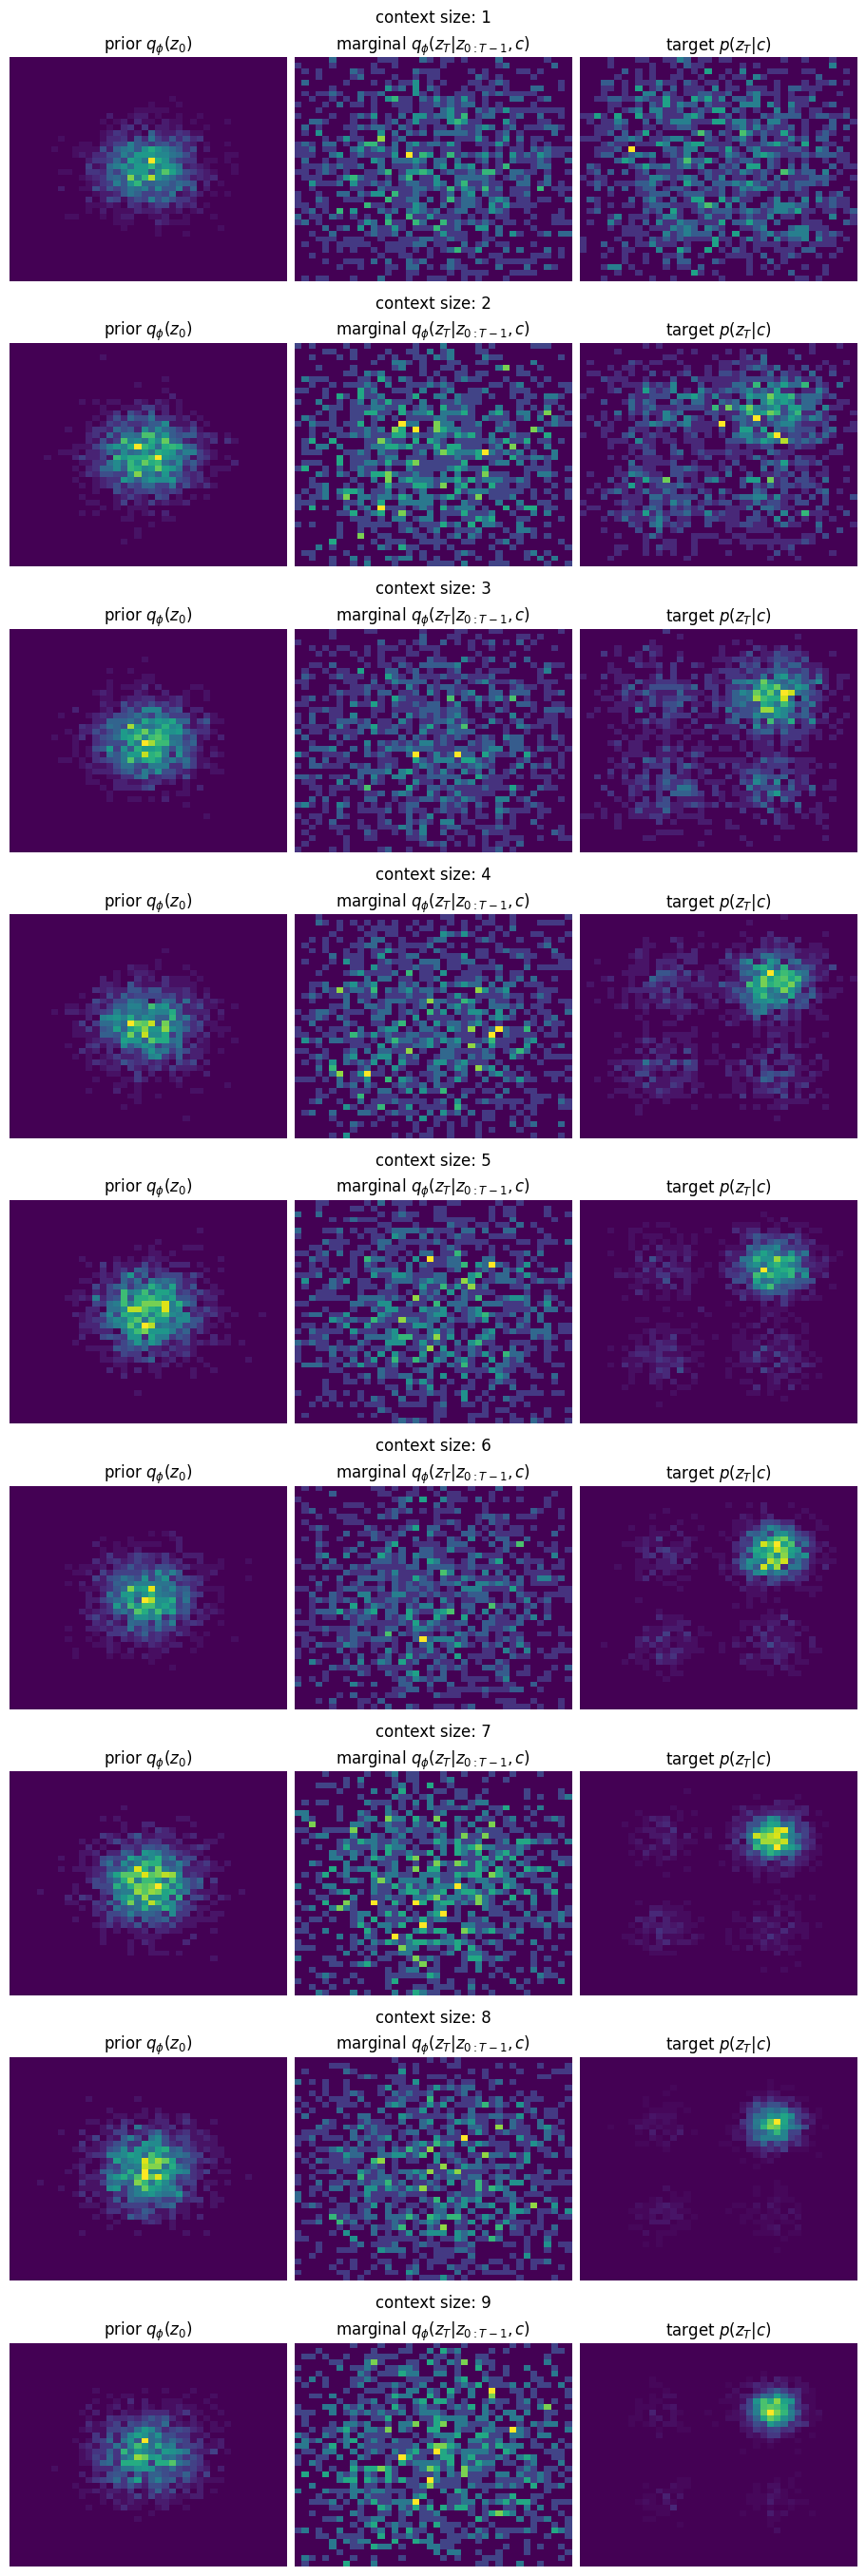

In [10]:
visualize_dvi_2d(device, model, dataset)